In [ ]:
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.optim as opt

import torchvision
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

In [ ]:
def get_data_set():

  transform_train = transforms.Compose([
      transforms.Resize((224, 224)), #配合VGG, ResNet, ... input大小
      #transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
      transforms.RandomCrop((224, 224)),
      transforms.ColorJitter(brightness=0.5),
      transforms.RandomRotation(10),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

  transform_test = transforms.Compose([
      transforms.Resize((224, 224)), 
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

  train = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
  test = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)

  return train, test

In [ ]:
train, test = get_data_set()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [ ]:
#沒有DataAugmentation
transform_train = transforms.Compose([
      transforms.Resize((224, 224)), 
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)

Files already downloaded and verified


In [ ]:
BATCH_SIZE = 100

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
#train_loader.dataset, test_loader.dataset

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# VGG16

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def draw(num_list, epochs, batch_num, y_label, title):
  x = range(len(num_list))
  plt.plot(x, num_list, '.-')

  labels = ['ep'+str(e)+'\n'+str(b)+'/'+str(batch_num) for e in range(1, epochs+1) for b in range(1, batch_num+1)]
  plt.xticks(ticks=x, labels=labels, rotation=0, fontsize=8) 

  plt.ylabel(y_label)
  plt.title(title)
  
  #plt.savefig(file_name)
  plt.show()

## 什麼都沒有

In [ ]:
model0 = models.vgg16(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
for param in model0.parameters():
  param.requires_grad=False

model0.classifier=nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=10, bias=True),
)

In [ ]:
model0 = model0.cuda()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = opt.Adam(model0.classifier.parameters(), lr=1e-5)

In [ ]:
loss_list = []
accu_list = []

epochs=5
for epoch in range(1, epochs+1):
  total_loss = 0
  total_correct = 0
  batch_num = 0
  
  for batch, (images,labels) in enumerate(train_loader, 1):
    model0.train() # 啟用BN和Dropout層 # model1.training

    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    
    y_pred = model0(images)
    _, pred = torch.max(y_pred, 1) # 返回每一行中最大值的那个元素，且返回其索引（返回最大元素在这一行的列索引）
    
    optimizer.zero_grad() # 清空梯度
    loss = loss_fn(y_pred, labels) # 計算loss
    loss.backward() # 將loss反向傳播, 計算梯度
    optimizer.step() # 更新權重
        
    total_loss += loss.data
    total_correct += torch.sum(pred==labels.data)
    
    if batch%100 == 0:
      print("epoch:%d, batch:%d, loss:%.4f, accuracy:%.4f"%(epoch, batch, (total_loss/batch), (total_correct/batch)))
      loss_list.append(total_loss/batch)
      accu_list.append(total_correct/batch)
      batch_num += 1

epoch:1, batch:100, loss:1.8250, accuracy:47.7500
epoch:1, batch:200, loss:1.3909, accuracy:59.3500
epoch:1, batch:300, loss:1.1631, accuracy:65.1800
epoch:1, batch:400, loss:1.0269, accuracy:68.6075
epoch:1, batch:500, loss:0.9364, accuracy:70.9400
epoch:2, batch:100, loss:0.4788, accuracy:83.9500
epoch:2, batch:200, loss:0.4707, accuracy:84.1900
epoch:2, batch:300, loss:0.4653, accuracy:84.2533
epoch:2, batch:400, loss:0.4548, accuracy:84.5800
epoch:2, batch:500, loss:0.4501, accuracy:84.7460
epoch:3, batch:100, loss:0.3630, accuracy:88.0200
epoch:3, batch:200, loss:0.3579, accuracy:88.2200
epoch:3, batch:300, loss:0.3532, accuracy:88.3067
epoch:3, batch:400, loss:0.3503, accuracy:88.3250
epoch:3, batch:500, loss:0.3472, accuracy:88.4100
epoch:4, batch:100, loss:0.2730, accuracy:91.6700
epoch:4, batch:200, loss:0.2746, accuracy:91.3150
epoch:4, batch:300, loss:0.2772, accuracy:91.0400
epoch:4, batch:400, loss:0.2767, accuracy:90.9375
epoch:4, batch:500, loss:0.2745, accuracy:90.9120


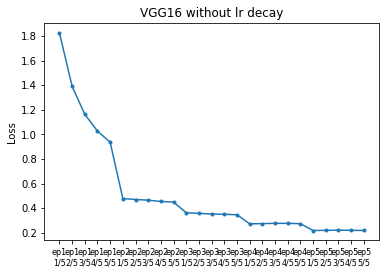

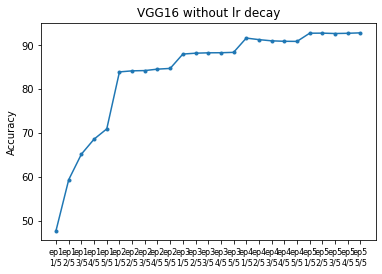

In [ ]:
loss_list = [i.cpu() for i in loss_list]
draw(loss_list, epochs, batch_num, 'Loss', '')

accu_list = [i.cpu() for i in accu_list]
draw(accu_list, epochs, batch_num, 'Accuracy', '')

In [ ]:
total_loss = 0
total_correct = 0

for batch, (images,labels) in enumerate(test_loader, 1):
  model0.eval() # 不啟用BN和Dropout層

  images=Variable(images.cuda())
  labels=Variable(labels.cuda())
  
  y_pred = model0(images)
  _, pred = torch.max(y_pred, 1)
  
  loss = loss_fn(y_pred,labels)
  #loss.backward()
  
  total_loss += loss.data
  total_correct += torch.sum(pred==labels.data)

print("loss:%.4f, accuracy:%.4f"%((total_loss/batch), (total_correct/batch)))

loss:0.4045, accuracy:86.5400


## LR Decay

In [ ]:
model3 = models.vgg16(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
for param in model3.parameters():
  param.requires_grad=False

model3.classifier=nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=10, bias=True),
)

In [ ]:
model3 = model3.cuda()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = opt.Adam(model3.classifier.parameters(), lr=1e-4)
lr_scheduler = opt.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)

In [ ]:
loss_list = []
accu_list = []
#lr_list = []

epochs=5
for epoch in range(1, epochs+1):
  total_loss = 0
  total_correct = 0
  batch_num = 0
  
  for batch, (images,labels) in enumerate(train_loader, 1):
    model3.train()

    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    
    y_pred = model3(images)
    _, pred = torch.max(y_pred, 1)
    
    optimizer.zero_grad()
    loss = loss_fn(y_pred, labels)
    loss.backward()
    optimizer.step()
    
    total_loss += loss.data
    total_correct += torch.sum(pred==labels.data)

    if batch%100 == 0:
      print("epoch:%d, batch:%d, loss:%.4f, accuracy:%.4f"%(epoch, batch, (total_loss/batch), (total_correct/batch)))
      loss_list.append(total_loss/batch)
      accu_list.append(total_correct/batch)
      batch_num += 1

      lr_scheduler.step(total_loss/batch)
      #lr_list.append(lr_scheduler.optimizer.param_groups[0]['lr'])

epoch:1, batch:100, loss:0.9095, accuracy:68.8000
epoch:1, batch:200, loss:0.7336, accuracy:74.7400
epoch:1, batch:300, loss:0.6621, accuracy:76.9567
epoch:1, batch:400, loss:0.6162, accuracy:78.5700
epoch:1, batch:500, loss:0.5868, accuracy:79.5900
epoch:2, batch:100, loss:0.2798, accuracy:90.3400
epoch:2, batch:200, loss:0.2821, accuracy:90.2500
epoch:2, batch:300, loss:0.2845, accuracy:90.1500
epoch:2, batch:400, loss:0.2885, accuracy:89.9400
epoch:2, batch:500, loss:0.2914, accuracy:89.8420
Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.
epoch:3, batch:100, loss:0.1471, accuracy:95.3900
epoch:3, batch:200, loss:0.1386, accuracy:95.6950
epoch:3, batch:300, loss:0.1344, accuracy:95.8500
epoch:3, batch:400, loss:0.1302, accuracy:95.9525
epoch:3, batch:500, loss:0.1244, accuracy:96.1360
epoch:4, batch:100, loss:0.0933, accuracy:97.1600
epoch:4, batch:200, loss:0.0921, accuracy:97.2450
epoch:4, batch:300, loss:0.0891, accuracy:97.3367
epoch:4, batch:400, loss:0.0888, accur

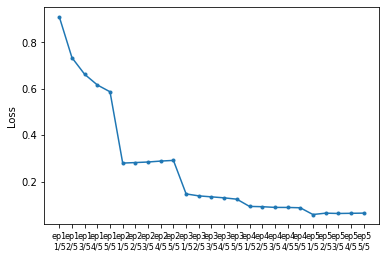

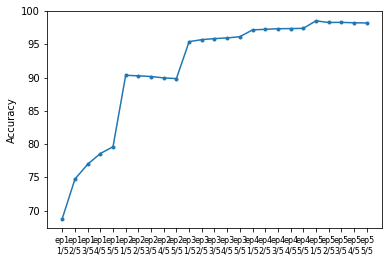

In [ ]:
loss_list = [i.cpu() for i in loss_list]
draw(loss_list, epochs, batch_num, 'Loss', '')

accu_list = [i.cpu() for i in accu_list]
draw(accu_list, epochs, batch_num, 'Accuracy', '')

In [ ]:
#Confusion Matrix
heatmap = pd.DataFrame(data=0, index=classes, columns=classes)

total_loss = 0
total_correct = 0

for batch, (images,labels) in enumerate(test_loader, 1):
  model3.eval()

  images=Variable(images.cuda())
  labels=Variable(labels.cuda())
  
  y_pred = model3(images)
  _, pred = torch.max(y_pred, 1)

  for i in range(BATCH_SIZE):
    true_label = labels[i].item()
    pred_label = pred[i].item()
    heatmap.iloc[true_label, pred_label] += 1
  
  loss = loss_fn(y_pred,labels)
  #loss.backward()
  
  total_loss += loss.data
  total_correct += torch.sum(pred==labels.data)

print("loss:%.4f, accuracy:%.4f"%((total_loss/batch), (total_correct/batch)))

loss:0.4358, accuracy:87.5400


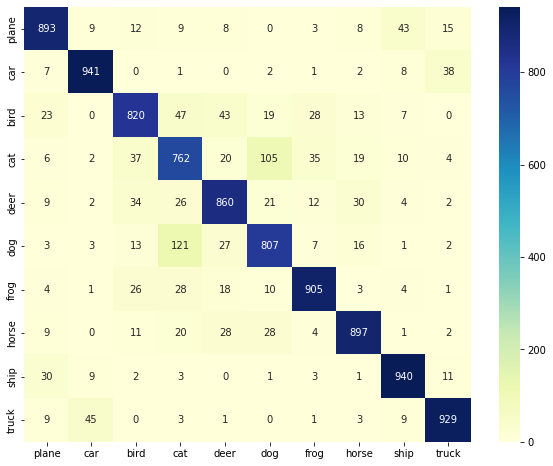

In [ ]:
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d", cmap="YlGnBu")
plt.show()

## Data Augmentation

In [ ]:
model1 = models.vgg16(weights="DEFAULT")
model1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# 只訓練最後 classifier 層參數

for param in model1.parameters():
  param.requires_grad=False

model1.classifier=nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=10, bias=True),
)

In [ ]:
model1 = model1.cuda()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = opt.Adam(model1.classifier.parameters(), lr=1e-5) # 1e-3 1e-4 1e-5

In [ ]:
loss_list = []
accu_list = []

epochs=5
for epoch in range(1, epochs+1):
  total_loss = 0
  total_correct = 0
  batch_num = 0
  
  for batch, (images,labels) in enumerate(train_loader, 1):
    model1.train() # 啟用BN和Dropout層 # model1.training

    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    
    y_pred = model1(images)
    _, pred = torch.max(y_pred, 1) # 返回每一行中最大值的那个元素，且返回其索引（返回最大元素在这一行的列索引）
    
    optimizer.zero_grad() # 清空梯度
    loss = loss_fn(y_pred, labels) # 計算loss
    loss.backward() # 將loss反向傳播, 計算梯度
    optimizer.step() # 更新權重
        
    total_loss += loss.data
    total_correct += torch.sum(pred==labels.data)
    
    if batch%100 == 0:
      print("epoch:%d, batch:%d, loss:%.4f, accuracy:%.4f"%(epoch, batch, (total_loss/batch), (total_correct/batch)))
      loss_list.append(total_loss/batch)
      accu_list.append(total_correct/batch)
      batch_num += 1

epoch:1, batch:100, loss:1.9826, accuracy:40.4900
epoch:1, batch:200, loss:1.6187, accuracy:50.2400
epoch:1, batch:300, loss:1.4088, accuracy:55.6633
epoch:1, batch:400, loss:1.2742, accuracy:59.2950
epoch:1, batch:500, loss:1.1805, accuracy:61.9080
epoch:2, batch:100, loss:0.7355, accuracy:75.2200
epoch:2, batch:200, loss:0.7276, accuracy:75.2250
epoch:2, batch:300, loss:0.7116, accuracy:75.8467
epoch:2, batch:400, loss:0.7010, accuracy:76.0600
epoch:2, batch:500, loss:0.6905, accuracy:76.4120
epoch:3, batch:100, loss:0.6351, accuracy:78.1700
epoch:3, batch:200, loss:0.6253, accuracy:78.6400
epoch:3, batch:300, loss:0.6157, accuracy:78.9100
epoch:3, batch:400, loss:0.6081, accuracy:79.1075
epoch:3, batch:500, loss:0.6029, accuracy:79.2960
epoch:4, batch:100, loss:0.5515, accuracy:80.6200
epoch:4, batch:200, loss:0.5569, accuracy:80.8000
epoch:4, batch:300, loss:0.5670, accuracy:80.3533
epoch:4, batch:400, loss:0.5620, accuracy:80.5250
epoch:4, batch:500, loss:0.5566, accuracy:80.6960


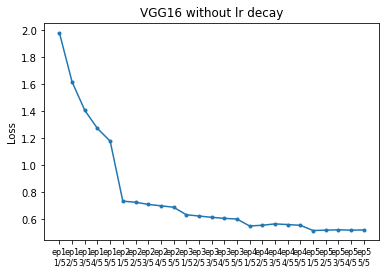

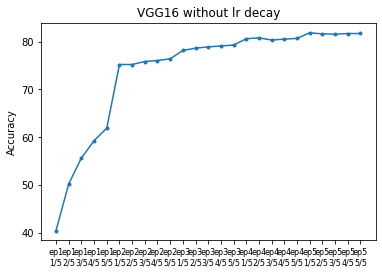

In [ ]:
loss_list = [i.cpu() for i in loss_list]
draw(loss_list, epochs, batch_num, 'Loss', 'VGG16 without lr decay')

accu_list = [i.cpu() for i in accu_list]
draw(accu_list, epochs, batch_num, 'Accuracy', 'VGG16 without lr decay')

In [ ]:
total_loss = 0
total_correct = 0

for batch, (images,labels) in enumerate(test_loader, 1):
  model1.eval() # 不啟用BN和Dropout層

  images=Variable(images.cuda())
  labels=Variable(labels.cuda())
  
  y_pred = model1(images)
  _, pred = torch.max(y_pred, 1)
  
  loss = loss_fn(y_pred,labels)
  #loss.backward()
  
  total_loss += loss.data
  total_correct += torch.sum(pred==labels.data)

print("loss:%.4f, accuracy:%.4f"%((total_loss/batch), (total_correct/batch)))

loss:0.4515, accuracy:84.6900


## Data Augmentation + LR Decay

In [ ]:
model2 = models.vgg16(weights="DEFAULT")

In [ ]:
for param in model2.parameters():
  param.requires_grad=False

model2.classifier=nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=10, bias=True),
)

In [ ]:
model2 = model2.cuda()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = opt.Adam(model2.classifier.parameters(), lr=1e-4)
lr_scheduler = opt.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)

In [ ]:
loss_list = []
accu_list = []
#lr_list = []

epochs=5
for epoch in range(1, epochs+1):
  total_loss = 0
  total_correct = 0
  batch_num = 0
  
  for batch, (images,labels) in enumerate(train_loader, 1):
    model2.train()

    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    
    y_pred = model2(images)
    _, pred = torch.max(y_pred, 1)
    
    optimizer.zero_grad()
    loss = loss_fn(y_pred, labels)
    loss.backward()
    optimizer.step()
    
    total_loss += loss.data
    total_correct += torch.sum(pred==labels.data)

    if batch%100 == 0:
      print("epoch:%d, batch:%d, loss:%.4f, accuracy:%.4f"%(epoch, batch, (total_loss/batch), (total_correct/batch)))
      loss_list.append(total_loss/batch)
      accu_list.append(total_correct/batch)
      batch_num += 1

      lr_scheduler.step(total_loss/batch)
      #lr_list.append(lr_scheduler.optimizer.param_groups[0]['lr'])

epoch:1, batch:100, loss:1.2212, accuracy:56.3100
epoch:1, batch:200, loss:1.0172, accuracy:63.8950
epoch:1, batch:300, loss:0.9291, accuracy:67.1200
epoch:1, batch:400, loss:0.8716, accuracy:69.1425
epoch:1, batch:500, loss:0.8317, accuracy:70.6600
epoch:2, batch:100, loss:0.6211, accuracy:78.0800
epoch:2, batch:200, loss:0.6244, accuracy:78.1800
epoch:2, batch:300, loss:0.6181, accuracy:78.3567
epoch:2, batch:400, loss:0.6133, accuracy:78.5025
epoch:2, batch:500, loss:0.6125, accuracy:78.4440
epoch:3, batch:100, loss:0.5490, accuracy:80.5400
epoch:3, batch:200, loss:0.5506, accuracy:80.6150
epoch:3, batch:300, loss:0.5529, accuracy:80.5667
epoch:3, batch:400, loss:0.5539, accuracy:80.5750
epoch:3, batch:500, loss:0.5535, accuracy:80.5920
Epoch 00015: reducing learning rate of group 0 to 1.0000e-05.
epoch:4, batch:100, loss:0.4668, accuracy:84.0900
epoch:4, batch:200, loss:0.4683, accuracy:83.8800
epoch:4, batch:300, loss:0.4668, accuracy:83.8767
epoch:4, batch:400, loss:0.4646, accur

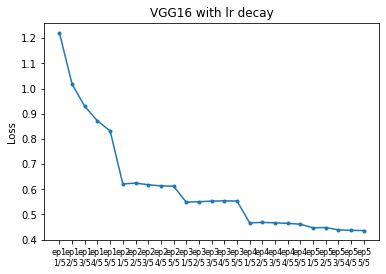

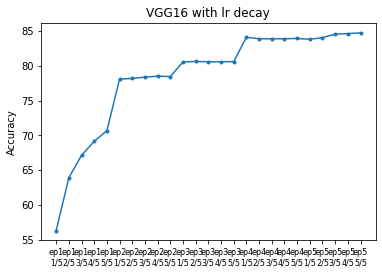

In [ ]:
loss_list = [i.cpu() for i in loss_list]
draw(loss_list, epochs, batch_num, 'Loss', 'VGG16 with lr decay')

accu_list = [i.cpu() for i in accu_list]
draw(accu_list, epochs, batch_num, 'Accuracy', 'VGG16 with lr decay')

In [ ]:
total_loss = 0
total_correct = 0

for batch, (images,labels) in enumerate(test_loader, 1):
  model2.eval()

  images=Variable(images.cuda())
  labels=Variable(labels.cuda())
  
  y_pred = model2(images)
  _, pred = torch.max(y_pred, 1)
  
  loss = loss_fn(y_pred,labels)
  #loss.backward()
  
  total_loss += loss.data
  total_correct += torch.sum(pred==labels.data)

print("loss:%.4f, accuracy:%.4f"%((total_loss/batch), (total_correct/batch)))

loss:0.4171, accuracy:85.7300


## VGG19 by LR Decay

In [ ]:
model_vgg19 = models.vgg19(weights="DEFAULT")
model_vgg19

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
for param in model_vgg19.parameters():
  param.requires_grad=False

model_vgg19.classifier=nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=10, bias=True),
)

In [ ]:
model_vgg19 = model_vgg19.cuda()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = opt.Adam(model_vgg19.classifier.parameters(), lr=1e-4)
lr_scheduler = opt.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)

In [ ]:
#VGG16: 24min; VGG19: 27min
loss_list = []
accu_list = []
#lr_list = []

epochs=5
for epoch in range(1, epochs+1):
  total_loss = 0
  total_correct = 0
  batch_num = 0
  
  for batch, (images,labels) in enumerate(train_loader, 1):
    model_vgg19.train()

    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    
    y_pred = model_vgg19(images)
    _, pred = torch.max(y_pred, 1)
    
    optimizer.zero_grad()
    loss = loss_fn(y_pred, labels)
    loss.backward()
    optimizer.step()
    
    total_loss += loss.data
    total_correct += torch.sum(pred==labels.data)

    if batch%100 == 0:
      print("epoch:%d, batch:%d, loss:%.4f, accuracy:%.4f"%(epoch, batch, (total_loss/batch), (total_correct/batch)))
      loss_list.append(total_loss/batch)
      accu_list.append(total_correct/batch)
      batch_num += 1

      lr_scheduler.step(total_loss/batch)
      #lr_list.append(lr_scheduler.optimizer.param_groups[0]['lr'])

epoch:1, batch:100, loss:0.8888, accuracy:69.3300
epoch:1, batch:200, loss:0.7299, accuracy:74.4500
epoch:1, batch:300, loss:0.6615, accuracy:76.7800
epoch:1, batch:400, loss:0.6183, accuracy:78.2800
epoch:1, batch:500, loss:0.5896, accuracy:79.2780
epoch:2, batch:100, loss:0.3028, accuracy:89.5500
epoch:2, batch:200, loss:0.3046, accuracy:89.5150
epoch:2, batch:300, loss:0.3084, accuracy:89.3300
epoch:2, batch:400, loss:0.3128, accuracy:89.0900
epoch:2, batch:500, loss:0.3152, accuracy:88.9960
Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.
epoch:3, batch:100, loss:0.1685, accuracy:94.8200
epoch:3, batch:200, loss:0.1570, accuracy:95.2200
epoch:3, batch:300, loss:0.1505, accuracy:95.4200
epoch:3, batch:400, loss:0.1456, accuracy:95.5225
epoch:3, batch:500, loss:0.1435, accuracy:95.5360
epoch:4, batch:100, loss:0.1068, accuracy:97.0900
epoch:4, batch:200, loss:0.1095, accuracy:96.8450
epoch:4, batch:300, loss:0.1072, accuracy:96.8833
epoch:4, batch:400, loss:0.1059, accur

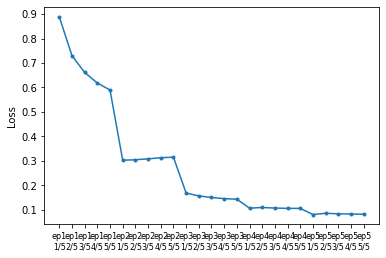

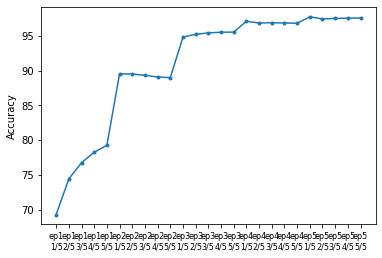

In [ ]:
loss_list = [i.cpu() for i in loss_list]
draw(loss_list, epochs, batch_num, 'Loss', '')

accu_list = [i.cpu() for i in accu_list]
draw(accu_list, epochs, batch_num, 'Accuracy', '')

In [ ]:
#Confusion Matrix
heatmap = pd.DataFrame(data=0, index=classes, columns=classes)

total_loss = 0
total_correct = 0

for batch, (images,labels) in enumerate(test_loader, 1):
  model_vgg19.eval()

  images=Variable(images.cuda())
  labels=Variable(labels.cuda())
  
  y_pred = model_vgg19(images)
  _, pred = torch.max(y_pred, 1)

  for i in range(BATCH_SIZE):
    true_label = labels[i].item()
    pred_label = pred[i].item()
    heatmap.iloc[true_label, pred_label] += 1
  
  loss = loss_fn(y_pred,labels)
  #loss.backward()
  
  total_loss += loss.data
  total_correct += torch.sum(pred==labels.data)

print("loss:%.4f, accuracy:%.4f"%((total_loss/batch), (total_correct/batch)))

loss:0.4092, accuracy:87.7200


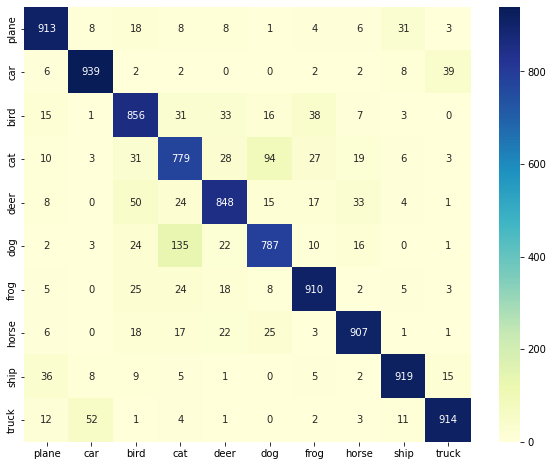

In [ ]:
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d", cmap="YlGnBu")
plt.show()

## 提高 Epoch

In [ ]:
model_vgg16 = models.vgg16(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
for param in model_vgg16.parameters():
  param.requires_grad=False

model_vgg16.classifier=nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=10, bias=True),
)

In [ ]:
model_vgg16 = model_vgg16.cuda()

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = opt.Adam(model_vgg16.classifier.parameters(), lr=1e-4)

lr_scheduler = opt.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True)

In [ ]:
loss_list = []
accu_list = []
#lr_list = []

epochs=5
for epoch in range(1, epochs+1):
  total_loss = 0
  total_correct = 0
  batch_num = 0
  
  for batch, (images,labels) in enumerate(train_loader, 1):
    model_vgg16.train()

    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    
    y_pred = model_vgg16(images)
    _, pred = torch.max(y_pred, 1)
    
    optimizer.zero_grad()
    loss = loss_fn(y_pred, labels)
    loss.backward()
    optimizer.step()
    
    total_loss += loss.data
    total_correct += torch.sum(pred==labels.data)

    if batch%100 == 0:
      print("epoch:%d, batch:%d, loss:%.4f, accuracy:%.4f"%(epoch, batch, (total_loss/batch), (total_correct/batch)))
      loss_list.append(total_loss/batch)
      accu_list.append(total_correct/batch)
      batch_num += 1

      lr_scheduler.step(total_loss/batch)
      #lr_list.append(lr_scheduler.optimizer.param_groups[0]['lr'])

epoch:1, batch:100, loss:0.9209, accuracy:68.2700
epoch:1, batch:200, loss:0.7373, accuracy:74.3050
epoch:1, batch:300, loss:0.6589, accuracy:77.0500
epoch:1, batch:400, loss:0.6198, accuracy:78.3175
epoch:1, batch:500, loss:0.5861, accuracy:79.4660
epoch:2, batch:100, loss:0.2743, accuracy:90.6300
epoch:2, batch:200, loss:0.2749, accuracy:90.5750
epoch:2, batch:300, loss:0.2797, accuracy:90.2833
epoch:2, batch:400, loss:0.2865, accuracy:90.0250
epoch:2, batch:500, loss:0.2902, accuracy:89.8840
Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.
epoch:3, batch:100, loss:0.1451, accuracy:95.5000
epoch:3, batch:200, loss:0.1358, accuracy:95.7450
epoch:3, batch:300, loss:0.1314, accuracy:95.9300
epoch:3, batch:400, loss:0.1280, accuracy:95.9900
epoch:3, batch:500, loss:0.1250, accuracy:96.0460
epoch:4, batch:100, loss:0.0955, accuracy:97.0400
epoch:4, batch:200, loss:0.0922, accuracy:97.1900
epoch:4, batch:300, loss:0.0911, accuracy:97.2500
epoch:4, batch:400, loss:0.0896, accur

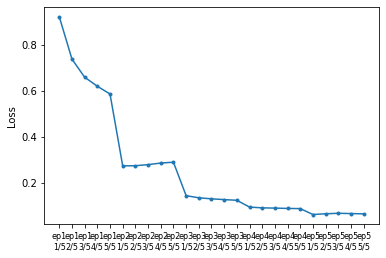

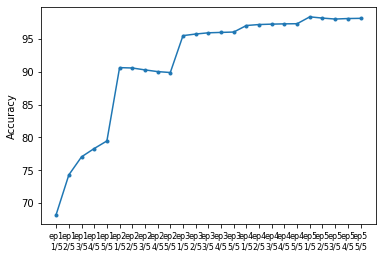

In [ ]:
loss_list = [i.cpu() for i in loss_list]
draw(loss_list, epochs, batch_num, 'Loss', '')

accu_list = [i.cpu() for i in accu_list]
draw(accu_list, epochs, batch_num, 'Accuracy', '')

In [ ]:
#Confusion Matrix
heatmap = pd.DataFrame(data=0, index=classes, columns=classes)

total_loss = 0
total_correct = 0

for batch, (images,labels) in enumerate(test_loader, 1):
  model_vgg16.eval()

  images=Variable(images.cuda())
  labels=Variable(labels.cuda())
  
  y_pred = model_vgg16(images)
  _, pred = torch.max(y_pred, 1)

  for i in range(BATCH_SIZE):
    true_label = labels[i].item()
    pred_label = pred[i].item()
    heatmap.iloc[true_label, pred_label] += 1
  
  loss = loss_fn(y_pred,labels)
  #loss.backward()
  
  total_loss += loss.data
  total_correct += torch.sum(pred==labels.data)

print("loss:%.4f, accuracy:%.4f"%((total_loss/batch), (total_correct/batch)))

loss:0.4423, accuracy:87.4200


In [ ]:
loss_list = []
accu_list = []
#lr_list = []

epochs=10
for epoch in range(6, epochs+1):
  total_loss = 0
  total_correct = 0
  batch_num = 0
  
  for batch, (images,labels) in enumerate(train_loader, 1):
    model_vgg16.train()

    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    
    y_pred = model_vgg16(images)
    _, pred = torch.max(y_pred, 1)
    
    optimizer.zero_grad()
    loss = loss_fn(y_pred, labels)
    loss.backward()
    optimizer.step()
    
    total_loss += loss.data
    total_correct += torch.sum(pred==labels.data)

    if batch%100 == 0:
      print("epoch:%d, batch:%d, loss:%.4f, accuracy:%.4f"%(epoch, batch, (total_loss/batch), (total_correct/batch)))
      loss_list.append(total_loss/batch)
      accu_list.append(total_correct/batch)
      batch_num += 1

      lr_scheduler.step(total_loss/batch)
      #lr_list.append(lr_scheduler.optimizer.param_groups[0]['lr'])

epoch:6, batch:100, loss:0.0489, accuracy:98.7300
epoch:6, batch:200, loss:0.0491, accuracy:98.7450
epoch:6, batch:300, loss:0.0492, accuracy:98.7700
epoch:6, batch:400, loss:0.0498, accuracy:98.7700
epoch:6, batch:500, loss:0.0494, accuracy:98.7820
Epoch 00030: reducing learning rate of group 0 to 1.0000e-07.
epoch:7, batch:100, loss:0.0481, accuracy:98.8500
epoch:7, batch:200, loss:0.0462, accuracy:98.9550
epoch:7, batch:300, loss:0.0453, accuracy:98.9833
epoch:7, batch:400, loss:0.0468, accuracy:98.9525
epoch:7, batch:500, loss:0.0474, accuracy:98.9080
epoch:8, batch:100, loss:0.0502, accuracy:98.6700
epoch:8, batch:200, loss:0.0472, accuracy:98.8200
Epoch 00037: reducing learning rate of group 0 to 1.0000e-08.
epoch:8, batch:300, loss:0.0471, accuracy:98.8600
epoch:8, batch:400, loss:0.0468, accuracy:98.9100
epoch:8, batch:500, loss:0.0475, accuracy:98.8800
epoch:9, batch:100, loss:0.0478, accuracy:98.9100
epoch:9, batch:200, loss:0.0464, accuracy:98.9850
epoch:9, batch:300, loss:0

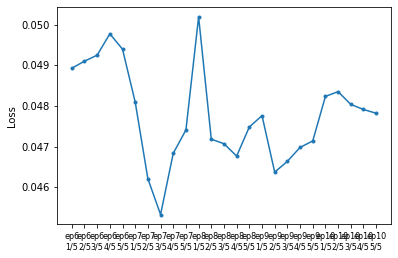

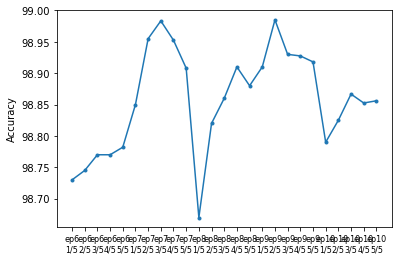

In [ ]:
def draw_10(num_list, epochs, batch_num, y_label, title):
  x = range(len(num_list))
  plt.plot(x, num_list, '.-')

  labels = ['ep'+str(e)+'\n'+str(b)+'/'+str(batch_num) for e in range(6, epochs+6) for b in range(1, batch_num+1)]
  plt.xticks(ticks=x, labels=labels, rotation=0, fontsize=8) 

  plt.ylabel(y_label)
  plt.title(title)
  
  #plt.savefig(file_name)
  plt.show()

loss_list = [i.cpu() for i in loss_list]
draw_10(loss_list, epochs, batch_num, 'Loss', '')

accu_list = [i.cpu() for i in accu_list]
draw_10(accu_list, epochs, batch_num, 'Accuracy', '')

In [ ]:
#Confusion Matrix
heatmap = pd.DataFrame(data=0, index=classes, columns=classes)

total_loss = 0
total_correct = 0

for batch, (images,labels) in enumerate(test_loader, 1):
  model_vgg16.eval()

  images=Variable(images.cuda())
  labels=Variable(labels.cuda())
  
  y_pred = model_vgg16(images)
  _, pred = torch.max(y_pred, 1)

  for i in range(BATCH_SIZE):
    true_label = labels[i].item()
    pred_label = pred[i].item()
    heatmap.iloc[true_label, pred_label] += 1
  
  loss = loss_fn(y_pred,labels)
  #loss.backward()
  
  total_loss += loss.data
  total_correct += torch.sum(pred==labels.data)

print("loss:%.4f, accuracy:%.4f"%((total_loss/batch), (total_correct/batch)))

loss:0.4420, accuracy:87.4200


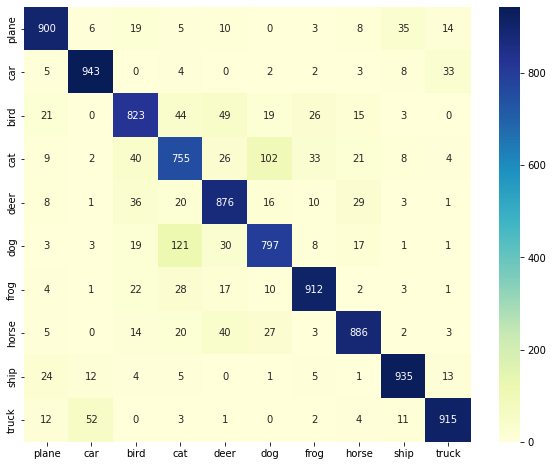

In [ ]:
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d", cmap="YlGnBu")
plt.show()

## 儲存模型

In [ ]:
#保存模型參數
torch.save(model_vgg16.state_dict(), '/content/drive/My Drive/model_weights.pth') #nthu email
#torch.save(model_vgg16.state_dict(), '/content/drive/My Drive/Colab Notebooks/model_weights.pth')
#torch.save(model, 'model.pth') #保存模型結構

In [ ]:
modelTEST = models.vgg16(weights="DEFAULT")

for param in modelTEST.parameters():
  param.requires_grad=False

modelTEST.classifier=nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=10, bias=True),
)

In [ ]:
#加載模型參數
modelTEST.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/model_weights.pth'))
#modelTEST = torch.load('model.pth') #加載模型結構

<All keys matched successfully>

In [ ]:
#測試有沒有繼承
modelTEST = modelTEST.cuda()

epochs=1
for epoch in range(1, epochs+1):
  total_loss = 0
  total_correct = 0
  
  for batch, (images,labels) in enumerate(train_loader, 1):
    modelTEST.train()

    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    
    y_pred = modelTEST(images)
    _, pred = torch.max(y_pred, 1)
    
    optimizer.zero_grad()
    loss = loss_fn(y_pred, labels)
    loss.backward()
    optimizer.step()
    
    total_loss += loss.data
    total_correct += torch.sum(pred==labels.data)

    if batch%100 == 0:
      print("epoch:%d, batch:%d, loss:%.4f, accuracy:%.4f"%(epoch, batch, (total_loss/batch), (total_correct/batch)))
      lr_scheduler.step(total_loss/batch)

epoch:1, batch:100, loss:0.4295, accuracy:85.1300
epoch:1, batch:200, loss:0.4275, accuracy:85.2600
epoch:1, batch:300, loss:0.4276, accuracy:85.1633
epoch:1, batch:400, loss:0.4279, accuracy:85.1300
epoch:1, batch:500, loss:0.4284, accuracy:85.0660
